In [1]:
import pqr

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)

import os; os.chdir("..")
os.chdir('C:/Users/tomtosov/Desktop/data/countries_data/countries_data/csv/usa')

# Загрузка и предобработка данных + подготовка дашборда

In [4]:
prices = pd.read_csv("close_price.csv", parse_dates=True, index_col=0)#['2005':]

mcap = pd.read_csv("mcap.csv", parse_dates=True, index_col=0)#['2005':]
pe = pd.read_csv("pe.csv", parse_dates=True, index_col=0)#['2005':]

volume = pd.read_csv("trading_volume.csv", parse_dates=True, index_col=0)#['2005':]
volume = prices * volume * 1000

prices, mcap, pe, volume = pqr.utils.replace_with_nan(prices, mcap, pe, volume)
prices, mcap, pe, volume = pqr.utils.align(prices, mcap, pe, volume)

In [5]:
universe = volume > 21_000_000
returns_calculator = pqr.utils.partial(
    pqr.calculate_returns,
    universe_returns=pqr.prices_to_returns(prices),
)

benchmark = pqr.Benchmark.from_universe(
    universe=universe,
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
)

In [6]:
table = pqr.metrics.Table()
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.mean_return,
        statistics=True,
        annualizer=1,
    ),
    multiplier=100,
    precision=2,
    name="Monthly Mean Return, %",
)
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.volatility,
        annualizer=1,
    ),
    multiplier=100,
    precision=2,
    name="Monthly Volatility, %",
)
table.add_metric(
    pqr.metrics.max_drawdown,
    multiplier=100,
    name="Maximum Drawdown, %",
)
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.mean_excess_return,
        benchmark=benchmark,
        statistics=True,
        annualizer=1,
    ),
    multiplier=100,
    precision=2,
    name="Monthly Mean Excess Return, %",
)
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.alpha,
        benchmark=benchmark,
        statistics=True,
        annualizer=1,
    ),
    multiplier=100,
    precision=2,
    name="Monthly Alpha, %",
    
)
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.beta,
        benchmark=benchmark,
        statistics=True,
    ),
    precision=2,
    name="Monthly Beta, %",
)

fig = pqr.metrics.Figure(
    pqr.metrics.compounded_returns,
    name="Compounded Returns",
    benchmark=benchmark,
    log_scale=True,
)

summary = pqr.metrics.Dashboard([table, fig])

In [7]:
dynamic_transform = pqr.utils.compose(
    pqr.utils.partial(pqr.factors.filter, universe=universe),
    pqr.utils.partial(pqr.factors.look_back_pct_change, period=6),
    pqr.utils.partial(pqr.factors.hold, period=6)
)

mom = dynamic_transform(prices)

# Строим time-series факторную модель

,Winners,Losers
"Monthly Mean Return, %",1.09*** (4.73),0.80*** (3.42)
"Monthly Volatility, %",5.54,5.63
"Maximum Drawdown, %",-53.10,-53.79
"Monthly Mean Excess Return, %",0.05 (0.53),-0.24 (-3.67)
"Monthly Alpha, %",0.13 (1.53),-0.20*** (-3.05)
"Monthly Beta, %",0.92*** (61.76),0.96*** (82.67)


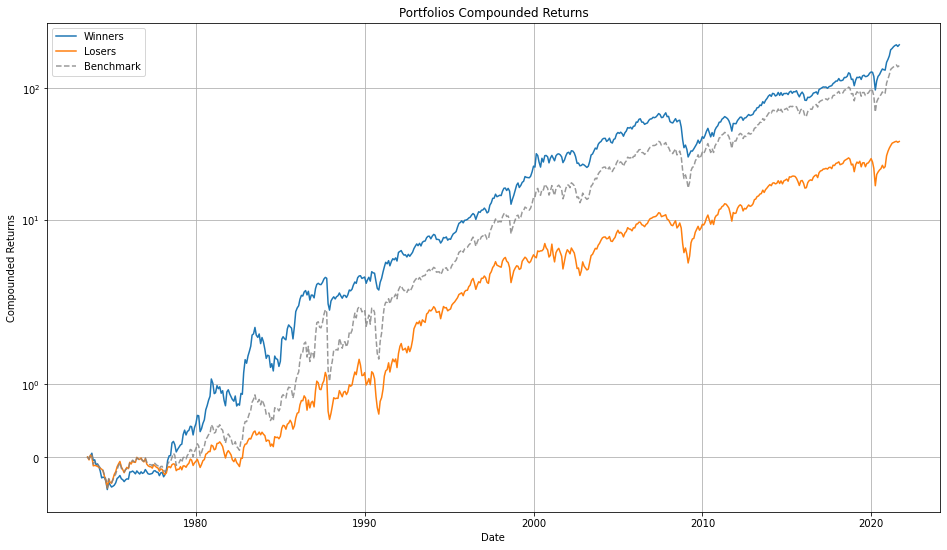

In [9]:
portfolios_ts = pqr.factors.backtest_factor_portfolios(
    factor=mom,
    strategies=pqr.factors.split_time_series([0.1], "more"),
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
)

summary.display(portfolios_ts)

# Строим quantile факторную модель с 5 квантилями

,Winners,Neutral 1,Neutral 2,Neutral 3,Losers
"Monthly Mean Return, %",1.17*** (4.59),0.87*** (4.31),0.87*** (4.30),0.84*** (3.70),0.89*** (2.72)
"Monthly Volatility, %",6.12,4.88,4.86,5.43,7.89
"Maximum Drawdown, %",-53.86,-49.06,-51.63,-52.91,-63.30
"Monthly Mean Excess Return, %",0.13 (1.18),-0.17 (-2.44),-0.17 (-2.29),-0.21 (-2.72),-0.15 (-0.98)
"Monthly Alpha, %",0.13 (1.24),0.00 (0.07),0.01 (0.19),-0.12 (-1.58),-0.43*** (-3.00)
"Monthly Beta, %",0.99*** (52.39),0.83*** (81.16),0.82*** (72.64),0.91*** (69.49),1.27*** (50.26)


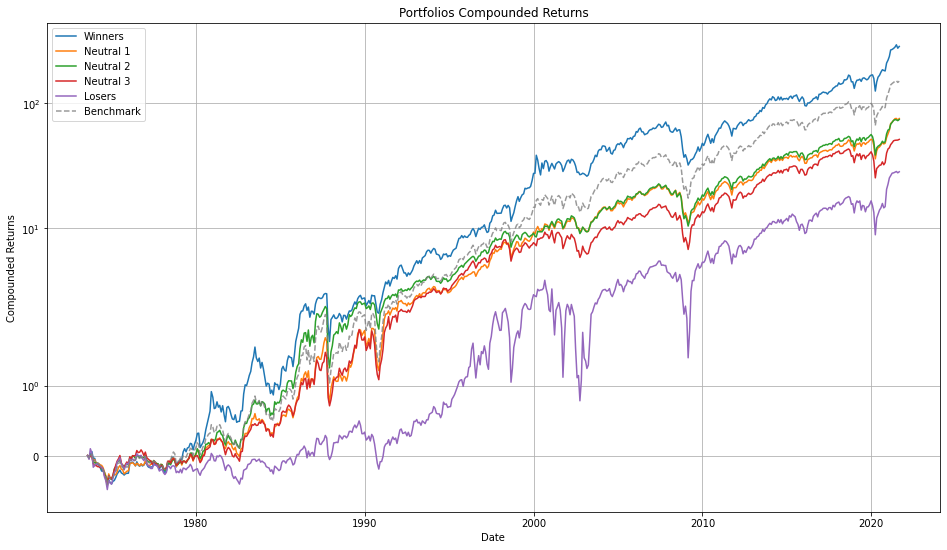

In [10]:
portfolios_q = pqr.factors.backtest_factor_portfolios(
    factor=mom,
    strategies=pqr.factors.split_quantiles(5, "more"),
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
)

summary.display(portfolios_q)

# Double time-series momentum

Преобразуем доходность бенчмарка в массив. Технический шаг, не меняющий сами значения

In [13]:
_, benchmark_returns = pqr.utils.align(mom, benchmark.returns)

benchmark_returns = benchmark_returns.to_numpy()[:, np.newaxis]

In [14]:
benchmark_returns

array([[ 7.58068733e-02],
       [-2.95495512e-02],
       [ 5.07168730e-02],
       [ 1.21399250e-02],
       [-1.25658570e-01],
       [ 3.55571995e-02],
       [-2.48754625e-02],
       [-5.61253879e-03],
       [-3.02436491e-02],
       [-2.92168996e-02],
       [-1.97903566e-02],
       [-1.82226096e-02],
       [-8.56582995e-02],
       [-7.72992018e-02],
       [-1.56463116e-01],
       [ 2.07219440e-01],
       [-5.09926506e-02],
       [-3.05211741e-02],
       [ 5.87979538e-02],
       [ 7.00490888e-02],
       [ 4.32750582e-02],
       [ 8.23873129e-02],
       [ 5.99706756e-02],
       [ 4.75545458e-02],
       [-8.30912772e-02],
       [-1.87399859e-02],
       [-3.90696269e-02],
       [ 3.80776602e-02],
       [ 1.65324272e-02],
       [-1.03045888e-02],
       [ 1.22653302e-01],
       [-4.35284860e-03],
       [ 3.00400237e-02],
       [-1.86192629e-02],
       [-1.12220165e-02],
       [ 6.60544620e-02],
       [-1.92406255e-02],
       [-1.39572099e-02],
       [ 2.1

Построим стратегию, которая:

1) Покупает акции с положительной доходностью, если доходность бенчмарка положительная;

2) Продает без покрытия акции с отрицательной доходностью, если доходность бенчмарка отрицательная

In [20]:
double_ts_portfolio = pqr.Portfolio.backtest(
    longs=pqr.factors.time_series(mom, min_threshold=0) & (benchmark_returns > 0),
    shorts=pqr.factors.time_series(mom, max_threshold=0) & (benchmark_returns < 0),
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
    name="Double TS Momentum",
)

,Winners,Losers,Double TS Momentum
"Monthly Mean Return, %",1.09*** (4.73),0.80*** (3.42),0.63*** (2.76)
"Monthly Volatility, %",5.54,5.63,5.53
"Maximum Drawdown, %",-53.10,-53.79,-48.99
"Monthly Mean Excess Return, %",0.05 (0.53),-0.24 (-3.67),-0.41 (-1.13)
"Monthly Alpha, %",0.13 (1.53),-0.20*** (-3.05),0.87*** (3.83)
"Monthly Beta, %",0.92*** (61.76),0.96*** (82.67),-0.23*** (-5.74)


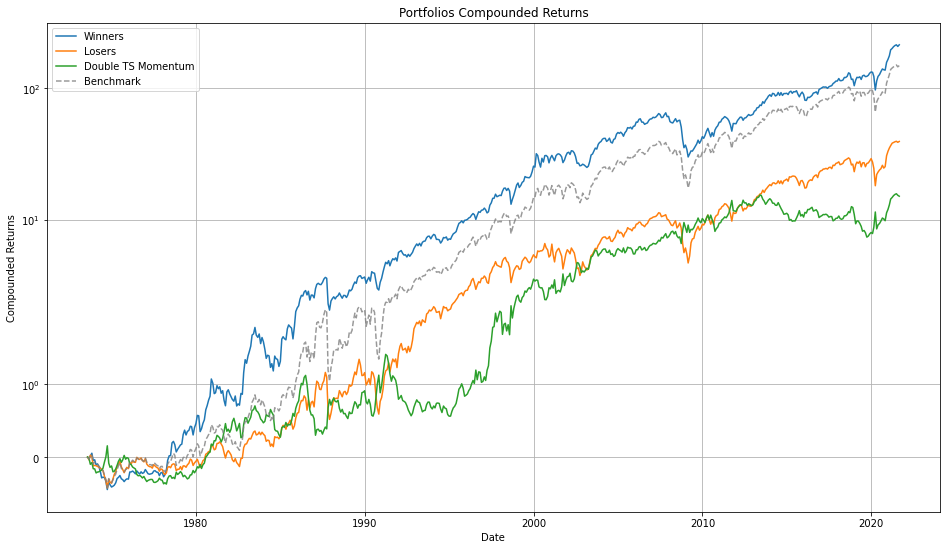

In [21]:
summary.display(portfolios_ts + [double_ts_portfolio])

Ряд доходности

In [17]:
double_ts_portfolio.returns

Double TS Momentum
1973-07-31    0.000000
1973-08-31   -0.022281
1973-09-28   -0.078475
1973-10-31    0.025441
1973-11-30   -0.090792
                ...   
2021-04-30    0.030153
2021-05-31    0.019903
2021-06-30    0.010764
2021-07-30   -0.024757
2021-08-31   -0.015333
Length: 578, dtype: float64

Веса в портфеля принимают значение 1 или -1 без промежуточных значений

<AxesSubplot:xlabel='Double TS Momentum'>

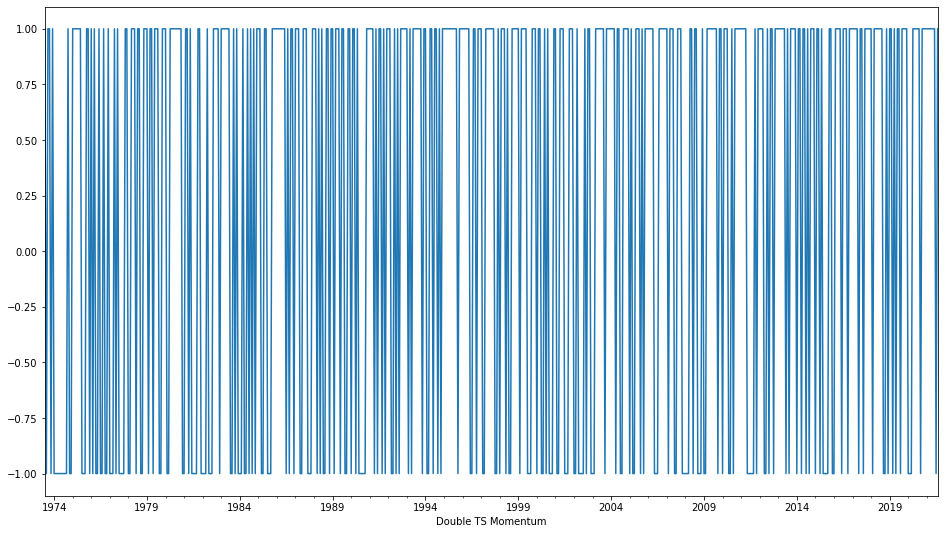

In [18]:
double_ts_portfolio.holdings.sum(axis=1).plot()

In [19]:
double_ts_portfolio.holdings

,1-800 CONTACTS DEAD,1-800-FLOWERS.COM 'A',180 LIFE SCIENCES,1895 BANCORP OF WISCONSIN,1ST BANC. IND DEAD,1ST CENTURY BANCSHARES DEAD,1ST CONSTITUTION BANCORP,1ST INDC.FINL.GP. DEAD,1ST SOURCE,1ST UNITED BANCORP DEAD,...,ZORAN DEAD,ZULILY CLASS A DEAD,ZUMIEZ,ZURICH REIN.CTR. DEAD,ZURN DEAD,ZWEIG STRATEGY FUND,ZYCON DEAD,ZYGO DEAD,ZYNEX,ZYTEC DEAD
Double TS Momentum,,,,,,,,,,,,,,,,,,,,,
1973-07-31,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1973-08-31,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1973-09-28,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1973-10-31,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1973-11-30,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-30,0.0,0.000587,0.000000,0.0,0.0,0.0,0.0,0.0,0.000587,0.0,...,0.0,0.0,0.000587,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2021-05-31,0.0,0.000587,0.000000,0.0,0.0,0.0,0.0,0.0,0.000587,0.0,...,0.0,0.0,0.000587,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2021-06-30,0.0,0.000587,0.000000,0.0,0.0,0.0,0.0,0.0,0.000587,0.0,...,0.0,0.0,0.000587,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


# Double CS momentum

Построим стратегию, которая:

1) Покупает акции с 20% наибольшей доходностью, если доходность бенчмарка положительная;

2) Продает без покрытия акции с 20% наименьшей доходностью, если доходность бенчмарка отрицательная

In [22]:
double_cs_portfolio = pqr.Portfolio.backtest(
    longs=pqr.factors.quantiles(mom, min_q=0.8, max_q=1.0) & (benchmark_returns > 0),
    shorts=pqr.factors.quantiles(mom, min_q=0.0, max_q=0.2) & (benchmark_returns < 0),
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
    name="Double CS Momentum",
)

,Winners,Losers,Double TS Momentum,Double CS Momentum
"Monthly Mean Return, %",1.09*** (4.73),0.80*** (3.42),0.63*** (2.76),0.79*** (2.80)
"Monthly Volatility, %",5.54,5.63,5.53,6.78
"Maximum Drawdown, %",-53.10,-53.79,-48.99,-50.90
"Monthly Mean Excess Return, %",0.05 (0.53),-0.24 (-3.67),-0.41 (-1.13),-0.25 (-0.63)
"Monthly Alpha, %",0.13 (1.53),-0.20*** (-3.05),0.87*** (3.83),1.07*** (3.84)
"Monthly Beta, %",0.92*** (61.76),0.96*** (82.67),-0.23*** (-5.74),-0.27*** (-5.58)


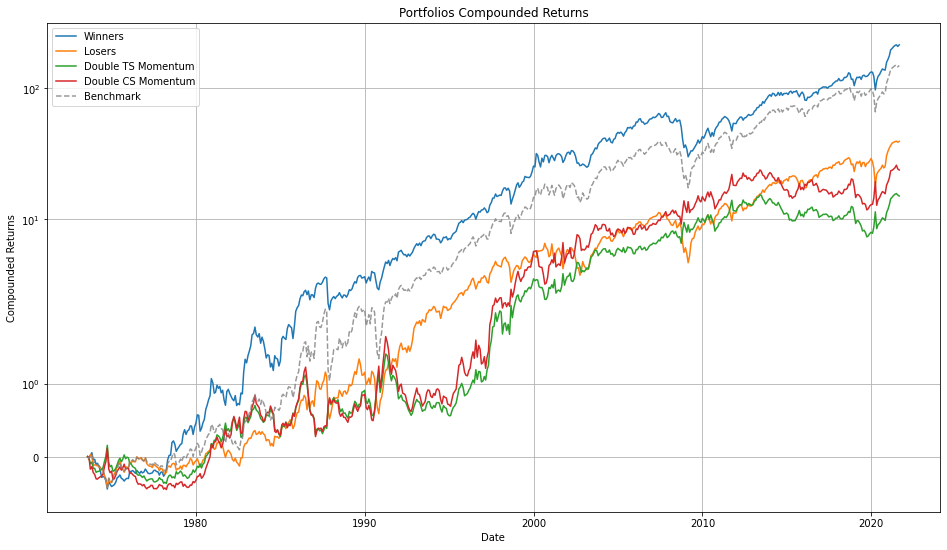

In [23]:
summary.display(portfolios_ts + [double_ts_portfolio] + [double_cs_portfolio])